In [1]:
%load_ext autoreload
%autoreload 2
import HammingCode
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc
import NeuralNetworkCorrection as network
import Autoencoder
import math
import Utils

2024-06-05 07:59:35.360844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 07:59:35.360949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 07:59:35.473287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 07:59:35.706106: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 07:59:37.955890: W tensorflow/compiler/tf2

In [2]:
variancia = 1
code_rate = 4/7
# amostra
Eb_dB_values = np.arange(3, 16, 1)

# Gerar dados de treinamento
training_sample_length = 10 ** 6
epoches = 100
batch_size = 64

In [3]:
training_data = {
    'original': [],
    'noisy': [],
    'info': []
}

training_information = network.get_training_data_set(training_sample_length)

for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(training_information, eb_db, variancia)
    training_data['noisy'].extend(info['split_noisy_original_data_15_11'])
    training_data['original'].extend(info['split_original_data_15_11'])

training_data['noisy'] = np.array(training_data['noisy'])
training_data['original'] = np.array(training_data['original'])

In [4]:
# Criar e treinar a rede neural
model = network.train_neural_network(training_data, epoches, batch_size)

Epoch 1/100
16620/16620 [==============================] - 97s 6ms/step - loss: 0.0262 - accuracy: 0.2063 - val_loss: 0.0246 - val_accuracy: 0.2298 - lr: 0.0010
Epoch 2/100
16620/16620 [==============================] - 96s 6ms/step - loss: 0.0243 - accuracy: 0.2072 - val_loss: 0.0243 - val_accuracy: 0.1980 - lr: 0.0010
Epoch 3/100
16620/16620 [==============================] - 95s 6ms/step - loss: 0.0239 - accuracy: 0.1960 - val_loss: 0.0236 - val_accuracy: 0.2104 - lr: 0.0010
Epoch 4/100
16620/16620 [==============================] - 96s 6ms/step - loss: 0.0236 - accuracy: 0.1994 - val_loss: 0.0236 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 5/100
16620/16620 [==============================] - 99s 6ms/step - loss: 0.0235 - accuracy: 0.1882 - val_loss: 0.0236 - val_accuracy: 0.2436 - lr: 0.0010
Epoch 6/100
16620/16620 [==============================] - 95s 6ms/step - loss: 0.0234 - accuracy: 0.1921 - val_loss: 0.0233 - val_accuracy: 0.0792 - lr: 0.0010
Epoch 7/100
16620/16620 [=========

In [5]:
autoencoder = Autoencoder.create_and_train_auto_encoder(training_data, epoches, batch_size)

Epoch 1/100
18467/18467 [==============================] - 78s 4ms/step - loss: 0.0426 - accuracy: 0.1962 - val_loss: 0.0231 - val_accuracy: 0.2342 - lr: 0.0010
Epoch 2/100
18467/18467 [==============================] - 78s 4ms/step - loss: 0.0232 - accuracy: 0.2204 - val_loss: 0.0232 - val_accuracy: 0.0710 - lr: 0.0010
Epoch 3/100
18467/18467 [==============================] - 77s 4ms/step - loss: 0.0232 - accuracy: 0.2160 - val_loss: 0.0231 - val_accuracy: 0.1920 - lr: 0.0010
Epoch 4/100
18467/18467 [==============================] - 77s 4ms/step - loss: 0.0232 - accuracy: 0.2134 - val_loss: 0.0231 - val_accuracy: 0.6251 - lr: 0.0010
Epoch 5/100
18467/18467 [==============================] - 77s 4ms/step - loss: 0.0232 - accuracy: 0.2151 - val_loss: 0.0231 - val_accuracy: 0.1195 - lr: 0.0010
Epoch 6/100
18467/18467 [==============================] - 76s 4ms/step - loss: 0.0232 - accuracy: 0.2033 - val_loss: 0.0231 - val_accuracy: 0.1252 - lr: 0.0010
Epoch 7/100
18467/18467 [=========

In [6]:
# Gerar dados de teste
amostras_ruidosas = []
amostras_originais = []
ML_result = []
tradicional_result = []
autoencoder_result = []


In [7]:
test_data = {
    'original': [],
    'info': []
}
test_sample_length = 10 ** 6
test_information = network.get_training_data_set(test_sample_length)

total_chunks = math.floor(test_sample_length / 11)
total_length_chunks = total_chunks * 11
smaller_array_len = test_sample_length - total_length_chunks

adjustment_test = 11 - smaller_array_len
padded_array = []
for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(test_information, eb_db, variancia)
    test_data['original'] = info['original_data']
    
    autoencoder_result.append(network.decode_and_correct(info['split_noisy_original_data_15_11'], autoencoder))
    ML_result.append(network.decode_and_correct(info['split_noisy_original_data_15_11'], model))
    tradicional_result.append(HammingCode.decode_sample(info['split_encoded_data']))
    padded_array = info['padded_array_original_data']
    print(eb_db)

3
4
5
6
7
8
9
10
11
12
13
14
15


In [8]:
BER_tradicional = []
BER_autoencoder = []
BER_ML = []

for i in range(0, len(autoencoder_result)):
    BER_ML.append(np.sum(np.array(ML_result[i]).astype(int) != padded_array) / len(padded_array))
    BER_tradicional.append(np.sum(np.array(tradicional_result[i]).astype(int) != test_data['original']) / len(test_data['original']))
    BER_autoencoder.append(np.sum(np.array(autoencoder_result[i]).astype(int) != padded_array) / len(padded_array))

# Calcular a BER teórica
Eb_coded = np.array([eb_db + 10*np.log10(code_rate) for eb_db in Eb_dB_values])
Eb_values = 10**(Eb_coded/10)
BER_teorica = 0.5 * erfc(np.sqrt(Eb_values))

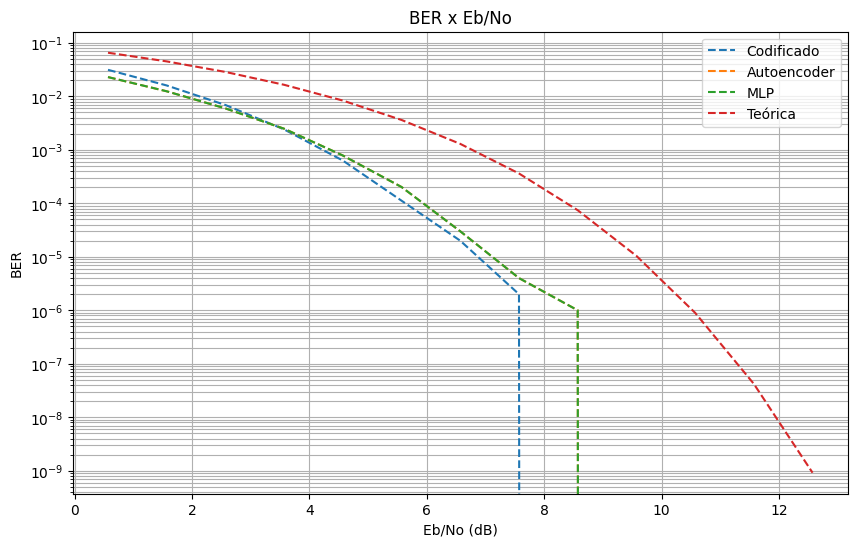

In [9]:
# Plotar as taxas de erro de bit simuladas e teóricas
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_coded, BER_tradicional, linestyle = '--', label='Codificado')
plt.semilogy(Eb_coded, BER_autoencoder, linestyle = '--', label='Autoencoder')
plt.semilogy(Eb_coded, BER_ML, linestyle = '--', label='MLP')
plt.semilogy(Eb_coded, BER_teorica, linestyle='--', label='Teórica')
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.grid(True, which='both')
plt.legend()
plt.title('BER x Eb/No')
plt.show()